# Project Scope and Setup

first, let's formally define our prject based on NYC Taxi dataset.

- **Objective:** Analyze the NYC Taxi dataset to indetify key patterns influencing trip duration, fare amounts and tipping.
- **Data Sources:** We will use The "NYC TLC Trip Record Data" from a Kaggle CSV file.
- **Tools**: We'll use Python (with Pandas , Matplotlib/Seaborn , and Scikit-learn ) for cleaning and analysis, and Power BI for the final dashboard.

- **Deliverables**: A complete Kaggle notebook for the analysis and a Power BI dashboard for visualization.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob 

## 2. Data Collection
Our first practical step is to load the data into a Kaggle notebook.

In [27]:
# 2. Define the path to the data
# This path points to the folder containing all the files
base_path = '/kaggle/input/tlc-trip-record-data-yellow-taxi/'

files_2021 = glob.glob(base_path + 'yellow_tripdata_2021-*.parquet')

print(f"Found {len(files_2021)} files for 2021:")
print(files_2021)

# 3. Load and combine all files
# Create an empty list to hold each month's DataFrame
list_of_dfs = []

for f in files_2021:
    print(f"Loading {f}...")
    # Load one month
    month_df = pd.read_parquet(f)
    # Add it to our list
    list_of_dfs.append(month_df)

# 4. Concatenate all DataFrames into one
print("Combining all files...")
data = pd.concat(list_of_dfs, ignore_index=True)

# 5. Display info
print("\n--- Combined Data Info ---")
data.info()
print("\n--- Combined Data Head ---")
print(data.head())

Found 12 files for 2021:
['/kaggle/input/tlc-trip-record-data-yellow-taxi/yellow_tripdata_2021-12.parquet', '/kaggle/input/tlc-trip-record-data-yellow-taxi/yellow_tripdata_2021-04.parquet', '/kaggle/input/tlc-trip-record-data-yellow-taxi/yellow_tripdata_2021-03.parquet', '/kaggle/input/tlc-trip-record-data-yellow-taxi/yellow_tripdata_2021-11.parquet', '/kaggle/input/tlc-trip-record-data-yellow-taxi/yellow_tripdata_2021-09.parquet', '/kaggle/input/tlc-trip-record-data-yellow-taxi/yellow_tripdata_2021-02.parquet', '/kaggle/input/tlc-trip-record-data-yellow-taxi/yellow_tripdata_2021-07.parquet', '/kaggle/input/tlc-trip-record-data-yellow-taxi/yellow_tripdata_2021-10.parquet', '/kaggle/input/tlc-trip-record-data-yellow-taxi/yellow_tripdata_2021-08.parquet', '/kaggle/input/tlc-trip-record-data-yellow-taxi/yellow_tripdata_2021-05.parquet', '/kaggle/input/tlc-trip-record-data-yellow-taxi/yellow_tripdata_2021-01.parquet', '/kaggle/input/tlc-trip-record-data-yellow-taxi/yellow_tripdata_2021-06.

## 3. Data Cleaning and Preprocessing

### 3.1 Feature Engineering: Calculate Trip Duration

In [28]:
data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60

### 3.2 Handle Missing Values

In [29]:
print(data.isnull().sum())

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count          1478695
trip_distance                  0
RatecodeID               1478695
store_and_fwd_flag       1478695
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     1478695
airport_fee              5641418
trip_duration                  0
dtype: int64


In [30]:
data.dropna(subset=['passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'congestion_surcharge', 'airport_fee'], inplace=True)

### 3.3 Handle Outliers and Impossible Values

In [31]:
print(f"\nOriginal data shape: {data.shape}")


Original data shape: (25262890, 20)


In [32]:
data = data[(data['trip_duration'] > 1) & (data['trip_duration'] < 600)]

# Filter for sensible trip distances (e.g., > 0)
data = data[data['trip_distance'] > 0]

# Filter for passenger counts (e.g., > 0)
data = data[data['passenger_count'] > 0]

# Filter for positive fares
data = data[data['fare_amount'] > 0]

print(f"Cleaned data shape: {data.shape}")

Cleaned data shape: (24123678, 20)


### 3.4 Feature Engineering: Extract Time Features

In [33]:
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['pickup_day_of_week'] = data['tpep_pickup_datetime'].dt.day_name()

In [34]:
print(data.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2021-12-01 00:19:51   2021-12-01 00:37:01              1.0   
1         2  2021-12-01 00:29:07   2021-12-01 00:45:13              2.0   
3         1  2021-12-01 00:10:18   2021-12-01 00:19:20              1.0   
4         1  2021-12-01 00:25:12   2021-12-01 00:39:07              1.0   
5         2  2021-12-01 00:28:50   2021-12-01 00:53:17              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           9.30         1.0                  N           138           141   
1           2.76         1.0                  N           238            42   
3           1.30         1.0                  N           148            87   
4           3.10         1.0                  N           231           246   
5          19.10         2.0                  N           132            75   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             1

## 4. Exploratory Data Analysis (EDA)

In [35]:
sns.set(style="whitegrid")

### 4.1 Correlation Heatmap

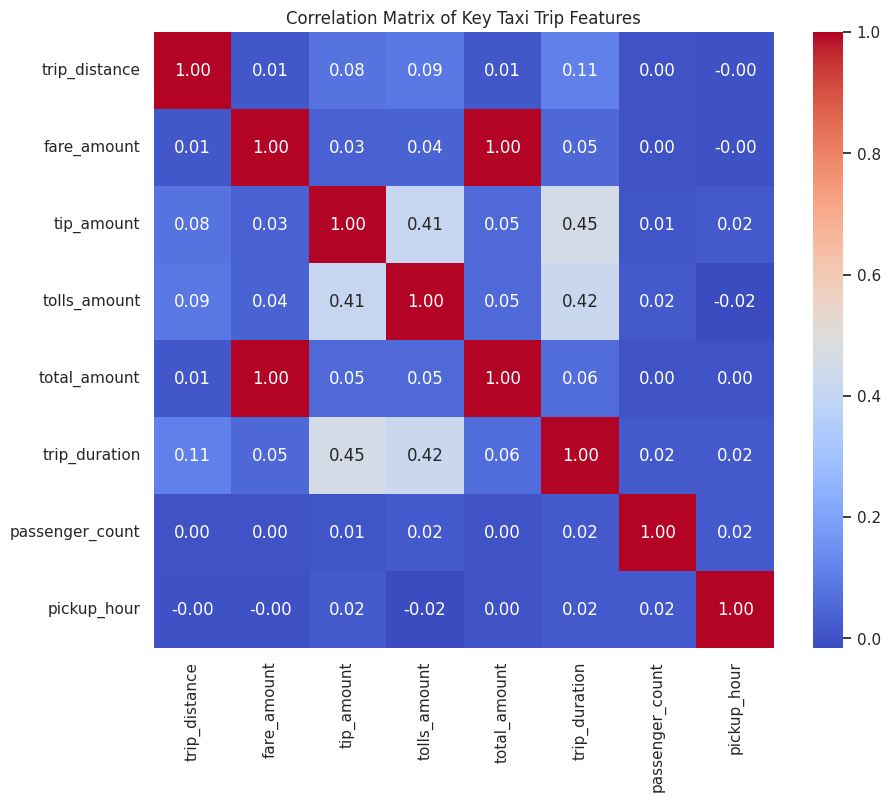

In [36]:
corr_columns = ['trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 
                'total_amount', 'trip_duration', 'passenger_count', 'pickup_hour']

corr_matrix = data[corr_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Taxi Trip Features')
plt.show()

Although the heatmap shows almost no linear correlation between `trip_distance` and `fare_amount`, this isn’t accurate in practical terms — longer trips generally lead to higher fares, which we’ll confirm visually late.

### 4.2 Analysis: Trips by Hour of the Day

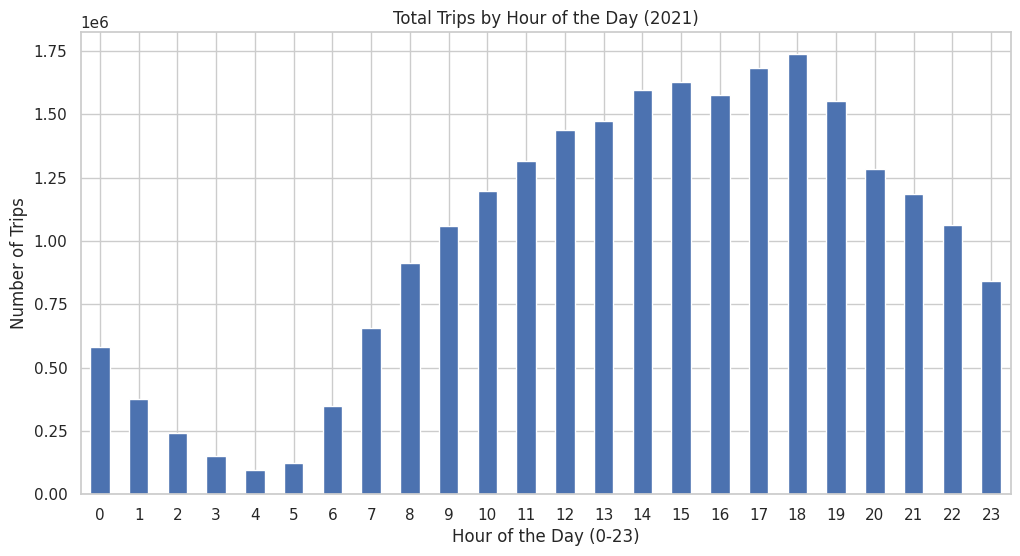

In [37]:
trips_by_hour = data.groupby('pickup_hour').size()

plt.figure(figsize=(12, 6))
trips_by_hour.plot(kind='bar')
plt.title('Total Trips by Hour of the Day (2021)')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.show()

### 4.3 Analysis: Trips by Day of the Week

In [38]:
trips_by_day = data.groupby('pickup_day_of_week').size()

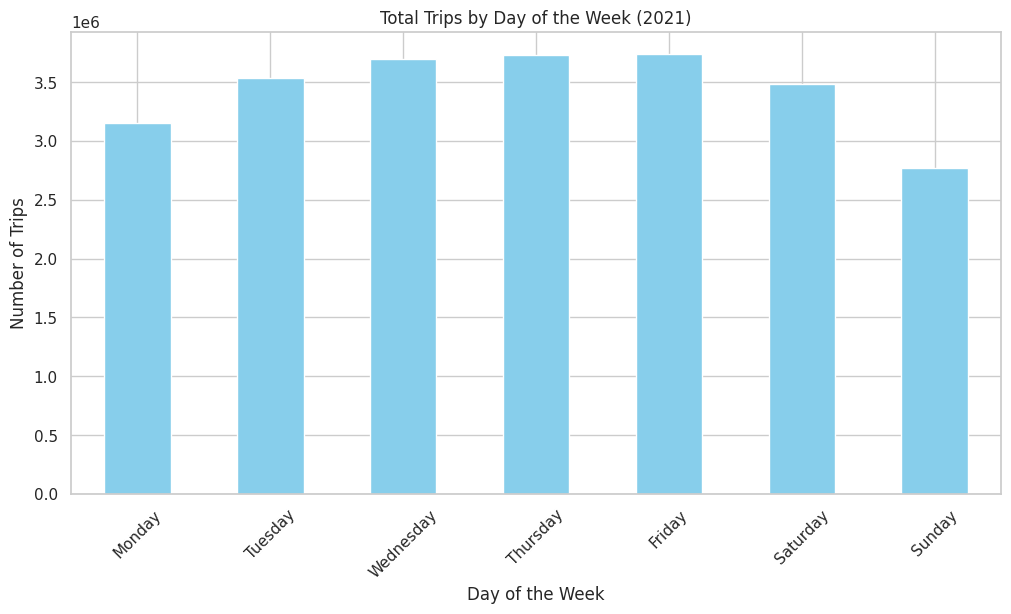

In [39]:
# We need to re-order the index so it plots in calendar order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trips_by_day = trips_by_day.reindex(day_order)

plt.figure(figsize=(12, 6))
trips_by_day.plot(kind='bar', color='skyblue')
plt.title('Total Trips by Day of the Week (2021)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()

Correlation for Standard Trips (RatecodeID=1):
               fare_amount  trip_distance
fare_amount        1.00000        0.03178
trip_distance      0.03178        1.00000

Plotting scatter plot for a sample of standard trips...


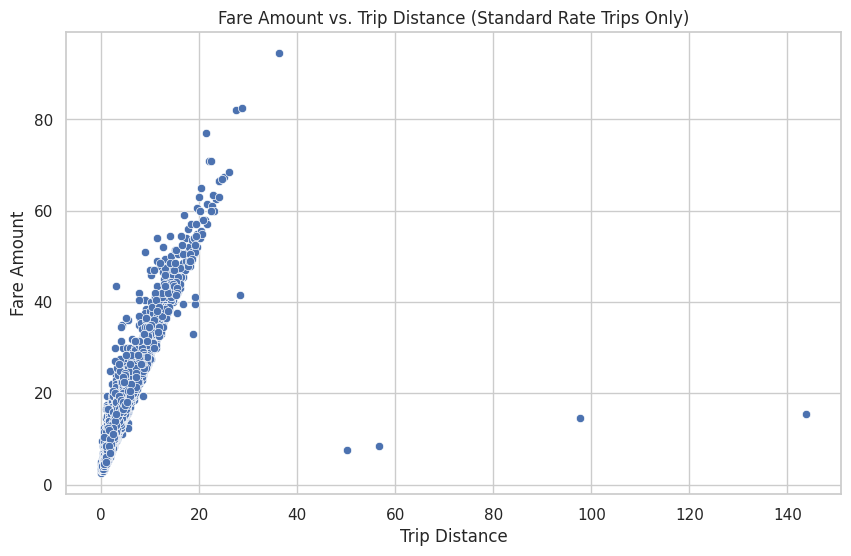

In [40]:
standard_trips = data[data['RatecodeID'] == 1]

# Re-calculate correlation for just standard trips
print("Correlation for Standard Trips (RatecodeID=1):")
print(standard_trips[['fare_amount', 'trip_distance']].corr())

# Plot a scatter plot to see the relationship
# We use .sample(10000) to avoid plotting millions of points
print("\nPlotting scatter plot for a sample of standard trips...")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=standard_trips.sample(10000), x='trip_distance', y='fare_amount')
plt.title('Fare Amount vs. Trip Distance (Standard Rate Trips Only)')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

## 5. Advanced Analysis (Linear Regression)

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np

### 5.1 Prepare our data
We will use the 'standard_trips' dataframe (RatecodeID == 1)

We also need to remove outliers for the model to be accurate

In [42]:
# Filter for reasonable distances and fares
# (e.g., distance < 100 miles, fare < $500)
model_data = standard_trips[
    (standard_trips['trip_distance'] < 100) & 
    (standard_trips['fare_amount'] < 500)
]

### 5.2 Define Features (X) and Target (y)
We want to predict 'fare_amount' based on 'trip_distance'

In [43]:
X = model_data[['trip_distance']]  # X must be a DataFrame (2D)
y = model_data['fare_amount']      # y can be a Series (1D)

### 5.3. Split the data into Training and Testing sets
We use 80% for training and 20% for testing


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples.")

Training on 18715672 samples, testing on 4678919 samples.


### 5.4 Create and Train the Model

In [45]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### 5.5 Print the Model's Coefficients
This is the 'y = mx + b' formula

In [46]:
print(f"\nModel Coefficient (m): {model.coef_[0]:.2f}")
print(f"Model Intercept (b): {model.intercept_:.2f}")
print(f"\nFormula: fare_amount = {model.coef_[0]:.2f} * trip_distance + {model.intercept_:.2f}")


Model Coefficient (m): 2.63
Model Intercept (b): 4.68

Formula: fare_amount = 2.63 * trip_distance + 4.68


### 5.6 Evaluate the Model
Make predictions on the test set

In [47]:
y_pred = model.predict(X_test)

Calculate R-squared (how well the model fits the data)
1.0 is a perfect fit

In [48]:
r2 = metrics.r2_score(y_test, y_pred)
print(f"\nModel R-squared: {r2:.4f}")


Model R-squared: 0.8838


### 5.7 Plot the results

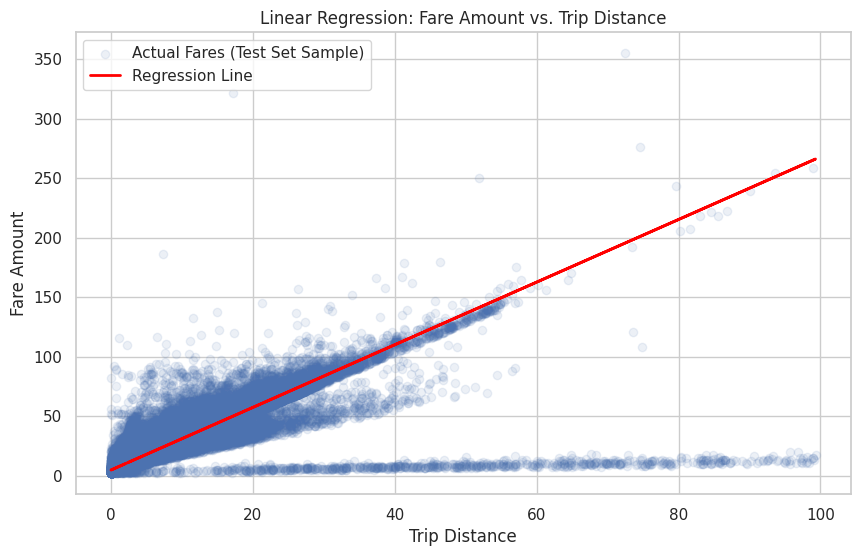

In [49]:
plt.figure(figsize=(10, 6))
# Plot the actual test data (as a scatter plot)
plt.scatter(X_test, y_test, alpha=0.1, label='Actual Fares (Test Set Sample)')
# Plot the regression line (what our model predicted)
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')
plt.title('Linear Regression: Fare Amount vs. Trip Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.legend()
plt.show()

let's export the aggregated data

In [59]:
# 1. Aggregate: Trips by Hour
print("Aggregating trips by hour...")
# We already have this from our EDA: trips_by_hour
# Let's rename it for clarity and save it
hourly_data = data.groupby('pickup_hour').size().to_frame(name='trip_count')
hourly_data.to_csv('hourly_trips.csv')


# 2. Aggregate: Trips by Day
print("Aggregating trips by day...")
# We also have this: trips_by_day
daily_data = data.groupby('pickup_day_of_week').size().to_frame(name='trip_count')
# Re-order it correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_data = daily_data.reindex(day_order)
daily_data.to_csv('daily_trips.csv')


# 3. Aggregate: Top 20 Pickup Locations
print("Aggregating top pickup locations...")
# This will show us the busiest pickup zones
top_pickups = data.groupby('PULocationID').size().to_frame(name='trip_count')
top_pickups = top_pickups.sort_values(by='trip_count', ascending=False).head(20)
top_pickups.to_csv('top_pickups.csv')


# 4. Aggregate: Financial Averages by Day
print("Aggregating financial data by day...")
# This helps us see which day is most profitable
financial_by_day = data.groupby('pickup_day_of_week')[[
    'fare_amount', 'tip_amount', 'total_amount', 'trip_duration'
]].mean()
financial_by_day = financial_by_day.reindex(day_order)
financial_by_day.to_csv('financial_by_day.csv')


# 5. Sample: Data for Scatter Plot
# We need a sample for any geographic or scatter plots
print("Sampling data for maps/scatter plots...")
map_data = data.sample(10_000_000)
# We only need a few columns for this
map_data_cleaned = map_data[['tpep_pickup_datetime', 'PULocationID', 'DOLocationID', 
                             'trip_distance', 'fare_amount', 'tip_amount']]
map_data_cleaned.to_csv('map_sample_data.csv')
map_data_cleaned.to_csv('map_sample_data.csv.gz', 
                        compression='gzip', 
                        index=False)


print("\nAll CSV files have been created and saved!")
print("You can find them in the 'Output' section of your Kaggle notebook.")

Aggregating trips by hour...
Aggregating trips by day...
Aggregating top pickup locations...
Aggregating financial data by day...
Sampling data for maps/scatter plots...

All CSV files have been created and saved!
You can find them in the 'Output' section of your Kaggle notebook.
